In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

### Basics of Derivative

In [3]:
# The slope of a function at a given point is equal to the value of its derivative at that point.

In [4]:
def f(x):
    return 3*x**2 - 4*x +5

In [5]:
f(3.0)

20.0

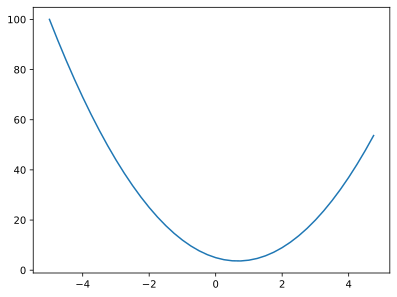

In [6]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [7]:
h = 0.0000001
x = 3.0
print(f'If we increase the x by h then the output of the function will increase by {f(x+h)-f(x)}')
print(f'Rise over run is slope {(f(x+h)-f(x))/h}')

If we increase the x by h then the output of the function will increase by 1.4000000305713911e-06
Rise over run is slope 14.000000305713911


In [8]:
# let's get more complex

a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [9]:
# derivate of d wrt a

h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c

a += h # bumped a by small amount
d2 = a*b + c

print('d1 ', d1)
print('d2 ', d2)
print('slope ', (d2-d1)/h) # change in d wrt h

# d2-d1 will determine the sign of slope


d1  4.0
d2  3.999699999999999
slope  -3.000000000010772


In [10]:
# derivate of d wrt b

h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c

b += h # bumped a by small amount
d2 = a*b + c

print('d1 ', d1)
print('d2 ', d2)
print('slope ', (d2-d1)/h)

d1  4.0
d2  4.0002
slope  2.0000000000042206


In [11]:
# derivate of d wrt c

h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c

c += h # bumped a by small amount
d2 = a*b + c

print('d1 ', d1)
print('d2 ', d2)
print('slope ', (d2-d1)/h)

# the function will increase by the same amount as c is increased, so the slope is 1
# because the d2-d1 will be equal to h

d1  4.0
d2  4.0001
slope  0.9999999999976694


In [128]:
class Value:

    # _children will contain the Value objects on which operations are applied
    # _op will contain the operator which was applied on _children
    # _label will contain any label
    def __init__(self, data, _children=(), _op='', label = ''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label

        # grad maintains the derivative of L w.r.t this value (self) (dL/dLabel)
        # initially it's 0, means no effect, means during initialization no value impacts L
        # because grad=0 means changing this value doesn't change L
        self.grad = 0.0

        # _backward method will help in computing the self.grad and other.grad.

        # the computation depends on the operator. when an operator is "applied" only then this function
        # changes from None to something.

        # for a leaf node, this will remain None because leaf node is NOT a result of operator applied on
        # any node. Hence, leaf._backward() won't have any grad to update.

        # Remember, calling this function will not update the grad of the current Value object but
        # it'll update the grad(s) of Value object(s) on which operator was applied.
        # Beause in every implementation of this method (which are available in the operator methods),
        # self.grad and other.grad are being updated and here self refers to the Value object on which
        # operator was applied, NOT the one on which this method is being called i.e. output

        # this will be called as output._backward() and it will update the self.grad and other.grad.
        self._backward = lambda: None

    def __repr__(self) -> str: # this function helps with printing the values.
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        # the following line of code is added if an integer is added to a Value object e.g. a + 1
        # this will check if other is a Value object or not, if not it will make other a Value object
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad # adding because grads accumulate when a variable is used more than once
            other.grad += 1.0 * out.grad # adding because grads accumulate when a variable is used more than once
        out._backward = _backward

        return out
    
    # this is a fallback for __add__ function
    # this is used in case the req is to multiply an int with Value object e.g. 2 + a
    # rather than doing 2.__add__(a), it will do a.__add__(2)
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * (-1)
    
    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        # the following line of code is added if an integer is multiplied to a Value object e.g. a * 1
        # this will check if other is a Value object or not, if not it will make other a Value object
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad # adding because grads accumulate when a variable is used more than once
            other.grad += self.data * out.grad # adding because grads accumulate when a variable is used more than once
        out._backward = _backward

        return out
    
    # this is a fallback for __mul__ function
    # this is used in case the req is to multiply an int with Value object e.g. 2 * a
    # rather than doing 2.__mul__(a), it will do a.__mul__(2)
    def __rmul__(self, other):
        return self*other
    
    # only supporting int/float powers for now, not Value object as power
    def __pow__(self, other):
        assert isinstance(other, (int, float))

        # other is not a Value object, so other.data will give error
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += (other * (self.data**(other -1))) * out.grad # adding because grads accumulate when a variable is used more than once
        out._backward = _backward

        return out

    
    def __truediv__(self, other):
        return self*(other**-1) # self / other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1.0 - t**2) * out.grad # adding because grads accumulate when a variable is used more than once
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        e = math.exp(x)
        out = Value(e, (self, ), 'exp')

        def _backward():
            self.grad += e * out.grad
        out._backward = _backward

        return out
    
    # this method will update the grads automatically for all nodes.
    # it builds the topological order of the graph and then call the _backward() method on all nodes.
    def backward(self):
        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)

        self.grad = 1.0 # initializing the last node's grad

        # in reversed order because the first node in topo is the leaf node and we want to backpropagate
        # starting from the last node (L)
        for node in reversed(topo):
            node._backward()

In [13]:
a = Value(2.0)
b = Value(-3.0)
a, b

(Value(data=2.0), Value(data=-3.0))

In [14]:
a + b # currently this won't work as python doesn't know how to add two Value objects
# it will give error TypeError: unsupported operand type(s) for +: 'Value' and 'Value'

Value(data=-1.0)

In [15]:
# after adding __add__, __mul__ functions and _children, _op, label & grad params to Value class
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
print(a + b)
print(a * b)
# d = a*b+c # (a.__mul__(b)).__sum__(c)
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
print(d)

Value(data=-1.0)
Value(data=-6.0)
Value(data=4.0)


In [16]:
d._prev # contains e and c as children

{Value(data=-6.0), Value(data=10.0)}

In [17]:
d._op # contains the '+' operator between e and c

'+'

In [18]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

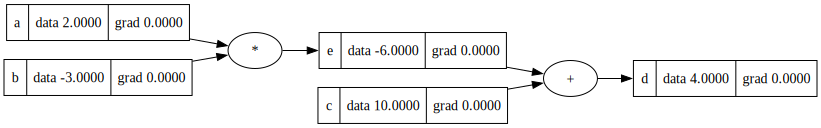

In [19]:
draw_dot(d)

In [20]:
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'
L


Value(data=-8.0)

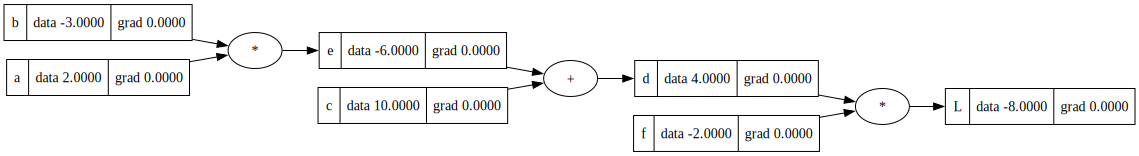

In [21]:
draw_dot(L)

### Backpropagation

In [22]:
# some of the vars (a, b,..., f) will be weights of the neural network and others represent the data.
# L is the loss function.
# we want to see how the change in weights impact the loss fn L.
# so, we'll compute the derivative of L with respect to each of these weight starting from the end i.e. L.

In [23]:
L.grad = 1.0 # dL/dL
# changing L by small amount h, changes L by h
# ((L+h) - L)/h = 1

In [24]:
# deriv of L wrt L
def rough1(): # just for proving stuff numerically

    h = 0.00001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'

    L1 = L.data
    L2 = L.data + h

    print((L2 - L1)/h)

rough1()

0.9999999999621422


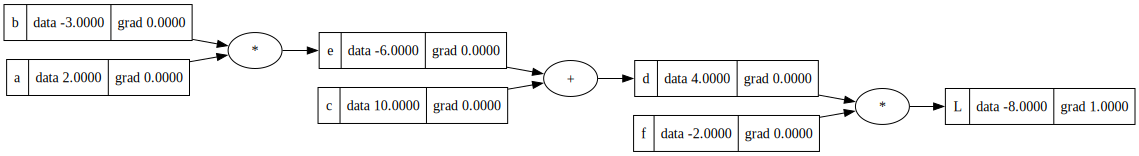

In [25]:
draw_dot(L)

In [26]:
# derivative of L wrt a
def rough2(): # just for proving stuff numerically

    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'

    L1 = L.data

    # bumped a by h
    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L = d*f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

rough2()

6.000000000021544


L = d*f

dL/df =? and dL/dd =?

dL/df =?

(f(x+h)-f(x))/h

(d*(f+h) - d*f)/h

= (d*f + d*h - d*f)/h

dL/df = d

similarly, dL/dd = f

so, the gradients of nodes having * between them is the value of the other variable

In [27]:
f.grad = 4.0 # value of d
d.grad = -2.0 # value of f

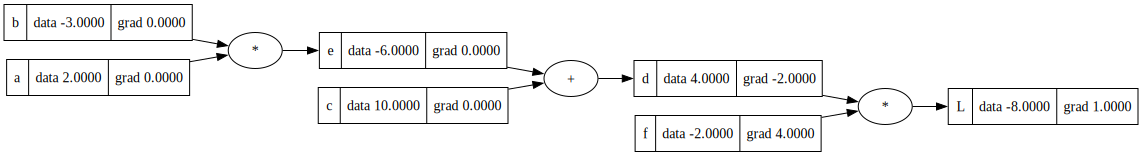

In [28]:
draw_dot(L)

In [29]:
# derivative of L wrt f
def rough3(): # just for proving stuff numerically

    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'

    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    # bumped f by h
    f = Value(-2.0 + h, label='f')
    L = d*f; L.label = 'L'
    L = d*f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

rough3()

3.9999999999995595


we know how d and f impact L, now we want to know how c and e impact L.

dL/dc =? and dL/de =?

L = d*f; d = c+e

let's first see how c and e impact d (*Local Derivative*)

dd/de =? and dd/dc =?

dd/dc =>

(f(x+h)-f(x))/h

= ((c+h)+e - (c+e))/h

= h/h = 1.0

similarly dd/de = 1.

so, the impact of + node is 1.0 gradient

Now we know how e and c impact d, how do we calculate e and c's impact on L.

The answer is **Chain Rule**.

*If a variable z depends on y and y depends on x, then z also depends on x, via the intermediate variable y.*

*If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 × 4 = 8 times as fast as the man.*

dz/dx = dz/dy * dy/dx

so,

WANT:

dL/dc

KNOW:

dL/dd, dd/dc

dL/dc = dL/dd * dd/dc

dL/dc = dL/dd * 1.0

dL/dc = dL/dd

so, what a + node does is it routes the gradient as it is because its local gradient is 1.0 and 1.0 times dL/dd is just dL/dd.

In [30]:
c.grad = -2.0 * 1.0 # d.grad * c's local grad
e.grad = -2.0 * 1.0 # d.grad * e's local grad

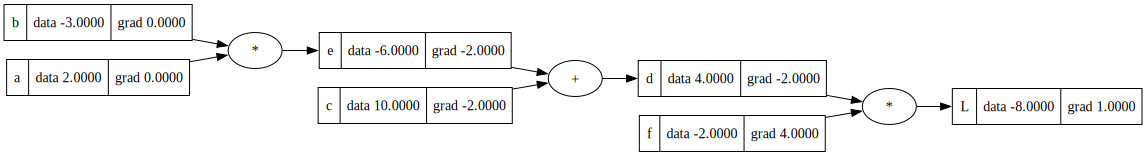

In [31]:
draw_dot(L)

In [32]:
# derivative of L wrt c
def rough4(): # just for proving stuff numerically

    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'

    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')

    # bumped c by h
    c = Value(10.0 + h, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L = d*f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

rough4()

-1.9999999999953388


dL/da =? and dL/db =?

e = a * b

we already know what happens to derivatives when there's a * operator, the gradients are values of nodes reversed. So,

de/da = b = -3.0

de/db = a = 2.0

KNOW

dL/de = -2.0

WANT

dL/da

by chain rule,

dL/da = dL/de * de/da

dL/da = -2.0 * -3.0

similarly,

dL/db = dL/de * de/db

dL/db = -2.0 * 2.0



In [33]:
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

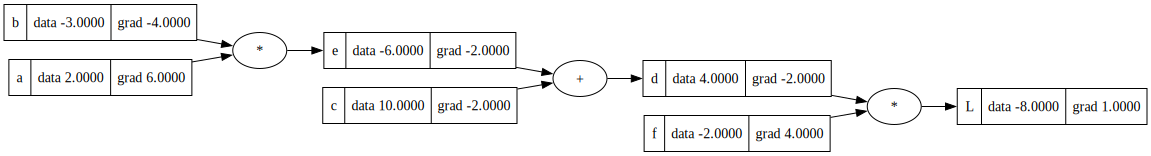

In [34]:
draw_dot(L)

In [35]:
# derivative of L wrt a
def rough5(): # just for proving stuff numerically

    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'

    L1 = L.data

    # bumped a by h
    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L = d*f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

rough5()

6.000000000021544


In [36]:
# let's see how changing the values of some nodes impacts L
# we'll change only the leaf nodes

a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# re-running the "forward pass"

e = a * b
d = e + c
L = d*f

L

Value(data=-7.286496)

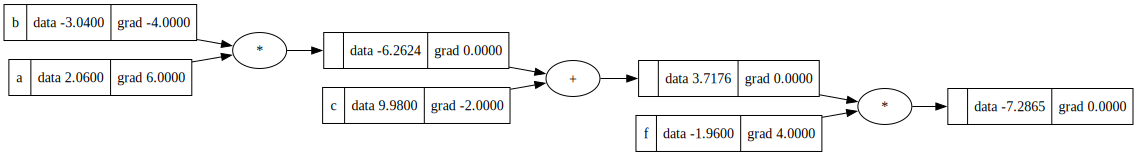

In [37]:
draw_dot(L)

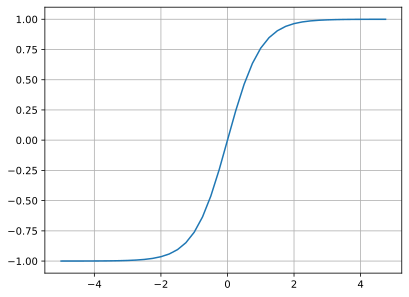

In [43]:
# tanh activation function
plt.plot(np.arange(-5, 5, 0.25), np.tanh(np.arange(-5, 5, 0.25))); plt.grid()

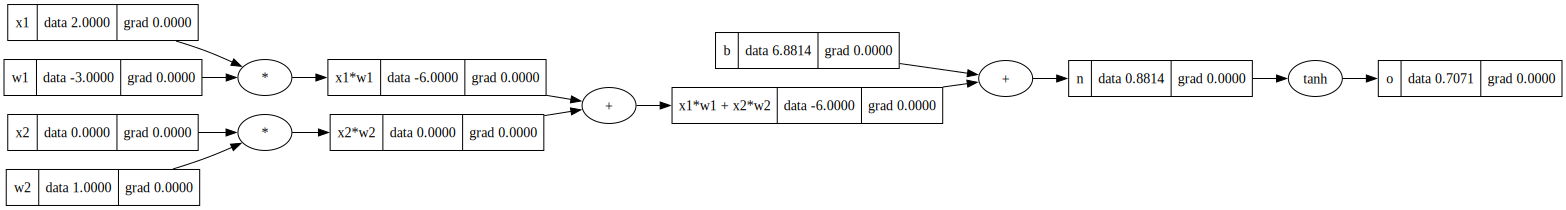

In [46]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1_x2w2 = x1w1+x2w2; x1w1_x2w2.label = 'x1*w1 + x2*w2'
n = x1w1_x2w2 + b; n.label = 'n'

# applying activation
o = n.tanh(); o.label = 'o'
draw_dot(o)

In [47]:
o.grad = 1.0

o = tanh(n)

do/dn = 1 - tanh(n)**2

do/dn = 1 - o**2

In [48]:
1 - o.data**2

0.4999999999999999

In [49]:
n.grad = 0.5 # 0.49999999999

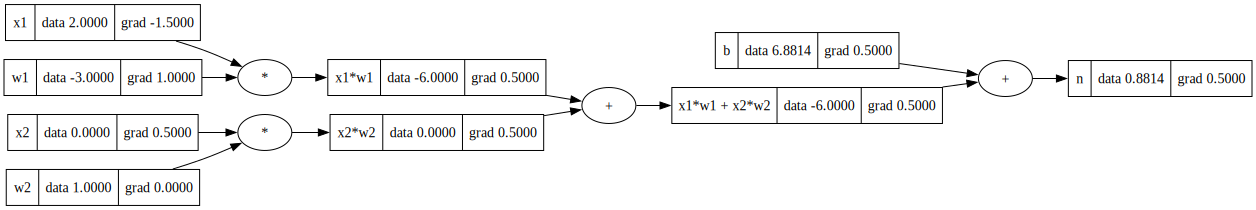

In [50]:
b.grad = 0.5
x1w1_x2w2.grad = 0.5

x1w1.grad = 0.5
x2w2.grad = 0.5

x1.grad = -3.0 * 0.5
w1.grad = 2.0 * 0.5
x2.grad = 1.0 * 0.5
w2.grad = 0.0 * 0.5

draw_dot(n)

If a variable has positive gradient, then it means increase its value will increase the final output.

In [73]:
# BACKPROPAGATION USING _backward() - semi-automatic

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1_x2w2 = x1w1+x2w2; x1w1_x2w2.label = 'x1*w1 + x2*w2'
n = x1w1_x2w2 + b; n.label = 'n'

# applying activation
o = n.tanh(); o.label = 'o'

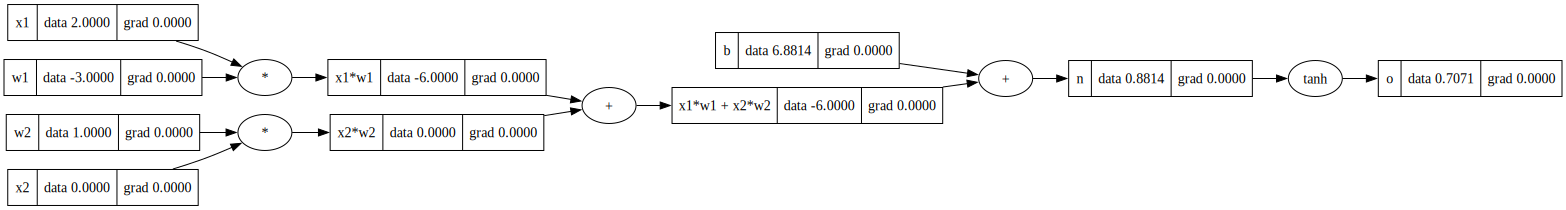

In [74]:
draw_dot(o)

In [75]:
o.grad = 1.0 # need to initialize this manually

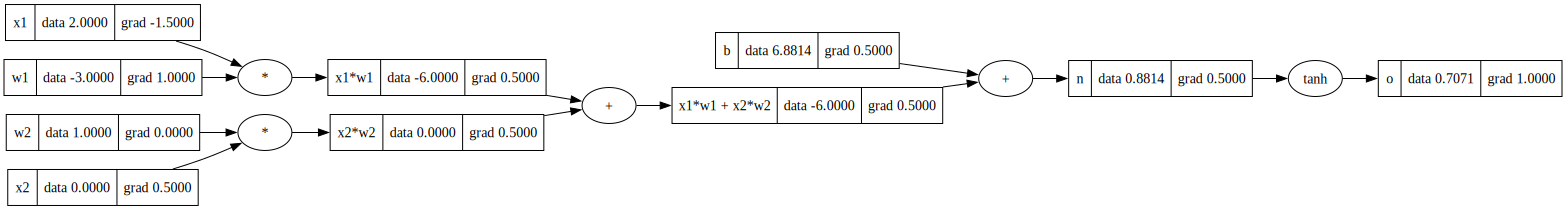

In [76]:
o._backward()

n._backward()

b._backward() # b is leaf node
x1w1_x2w2._backward()

x1w1._backward()
x2w2._backward()

draw_dot(o)

In [77]:
# BACKPROPAGATION USING backward() - fully-automatic

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1_x2w2 = x1w1+x2w2; x1w1_x2w2.label = 'x1*w1 + x2*w2'
n = x1w1_x2w2 + b; n.label = 'n'

# applying activation
o = n.tanh(); o.label = 'o'

In [78]:
o.backward()

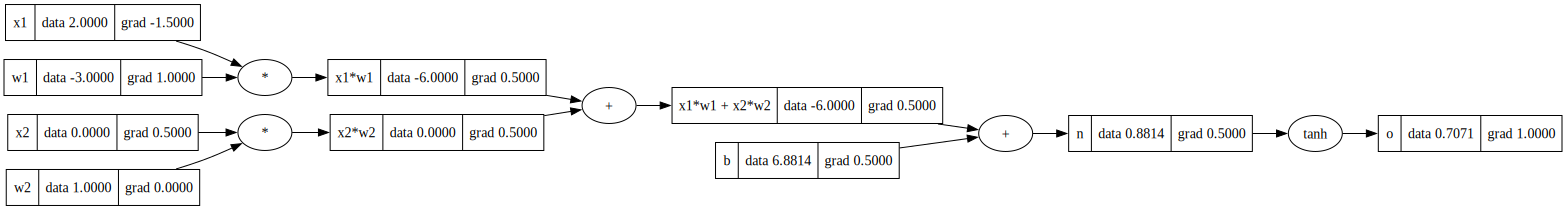

In [79]:
draw_dot(o)

**There's a problem**

If a variable is used more than once then it's grad is incorrectly updated.

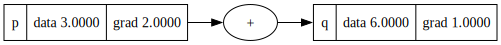

In [86]:
p = Value(3.0, label='p')
q = p + p; q.label = 'q'
q.backward()
draw_dot(q)

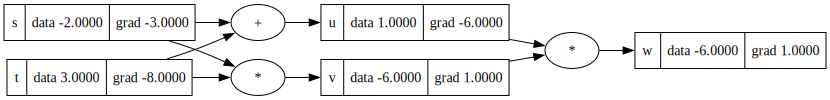

In [87]:
# one more example

s = Value(-2.0, label='s')
t = Value(3.0, label='t')
u = s + t; u.label='u'
v = s * t; v.label='v'
w = u * v; w.label='w'

w.backward()
draw_dot(w)


Above grads for u and v are incorrect (until we fixed the grad calculation)

def _backward():

    self.grad = 1.0 * out.grad
    
    other.grad = 1.0 * out.grad

Here, self and other are same Value objects. Modifying one is updating the other.

**Solution:**

The grads accumulate, so add up all the gradients

self.grad += 1.0 * out.grad
    
other.grad += 1.0 * out.grad

Breaking tanh to exp and division

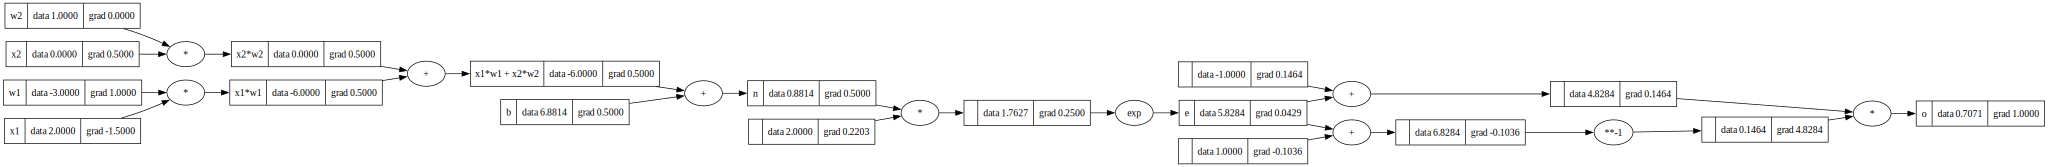

In [129]:
# BACKPROPAGATION USING _backward() - semi-automatic

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1_x2w2 = x1w1+x2w2; x1w1_x2w2.label = 'x1*w1 + x2*w2'
n = x1w1_x2w2 + b; n.label = 'n'

# o = n.tanh(); o.label = 'o'
#-----
e = (2*n).exp(); e.label = 'e'
# ee = e**2; ee.label = 'e**2'
o = (e-1) / (e+1); o.label = 'o'
#-----

o.backward()
draw_dot(o)

## Using PyTorch

In [131]:
import torch

In [139]:
# inputs x1, x2
x1 = torch.tensor(2.0).double(); x1.requires_grad = True
x2 = torch.tensor(0.0).double(); x2.requires_grad = True

#weights w1, w2
w1 = torch.tensor(-3.0).double(); w1.requires_grad = True
w2 = torch.tensor(1.0).double(); w2.requires_grad = True

b = torch.tensor(6.8813735870195432); b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()
print('--------')
print('x1', x1.grad.item())
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())


0.7071066904050358
--------
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0


In [209]:
class Neuron():

    # nin: number of inputs
    def __init__(self, nin: int):
        self.w = [Value(np.random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(np.random.uniform(-1, 1))
    
    # implements (w * x) + b
    def __call__(self, inputs: list):
        total = sum((wi*xi for wi, xi in zip(self.w, inputs)), self.b)
        out = total.tanh()
        return out


In [246]:
class Layer:
    
    # nin: number of inputs to one neuron
    # nout: number of neurons
    def __init__(self, nin: int, nout: int):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    # returns the outputs of all neurons
    def __call__(self, inputs: list):
        outs = [n(inputs) for n in self.neurons]

        # returning the element of list, which is a Value object, in case len(outs) == 1
        # for more than one elements in outs it will return the list
        # this modification is done for draw_dot function that takes only a root element
        # for multiple outputs (list), draw_dot will still fail.
        return outs[0] if len(outs) == 1 else outs

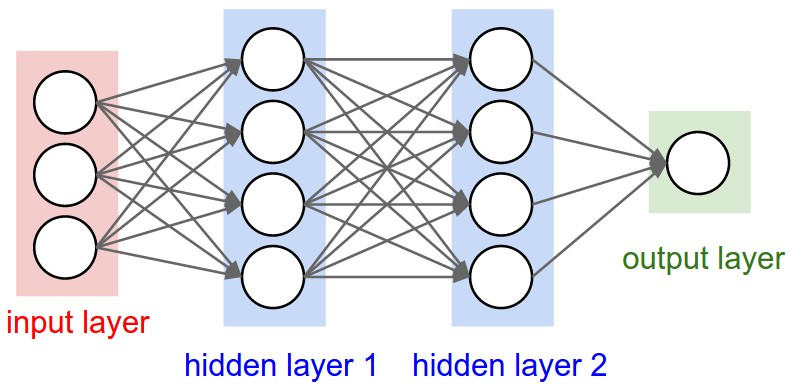

In [247]:
class MLP:

    # nouts: number of neurons in layers
    def __init__(self, nin, nouts: list):

        # e.g. nin = 2, nouts = [4, 4, 1] -- total 3 layers
        # sz = [2, 4, 4, 1]
        # Layer-1 = Layer(nin = 2, nout = 4) -- 4 neurons
        # Layer-2 = Layer(nin = 4, nout = 4) -- 4 neurons
        # Layer-3 = Layer(nin = 4, nout = 1) -- 1 neurons
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    # x = inputs
    def __call__(self, x: list):

        # here, initial input x is passed to first layer of neurons
        # there will a list of outputs of length equal to number of neurons in that layer
        # the outputs will contain the Value objects with value computed as sum((w * x), b)
        # x will be updated with the output of first layer and will be passed as input to next layer and so on.
        for layer in self.layers:
            x = layer(x)
        return x

In [213]:
x = [2.0, 3.0]
L = Layer(len(x), 4)
L(x)

[Value(data=-0.9687805514748624),
 Value(data=0.6368288337998887),
 Value(data=-0.9989529713926782),
 Value(data=-0.810490203355035)]

In [202]:
x+[4]

[2.0, 3.0, 4]

In [253]:
x = [2.0, 3.0, -1.0]
n = MLP(len(x), [4, 4, 1])
n(x)

Value(data=0.7063742570972458)

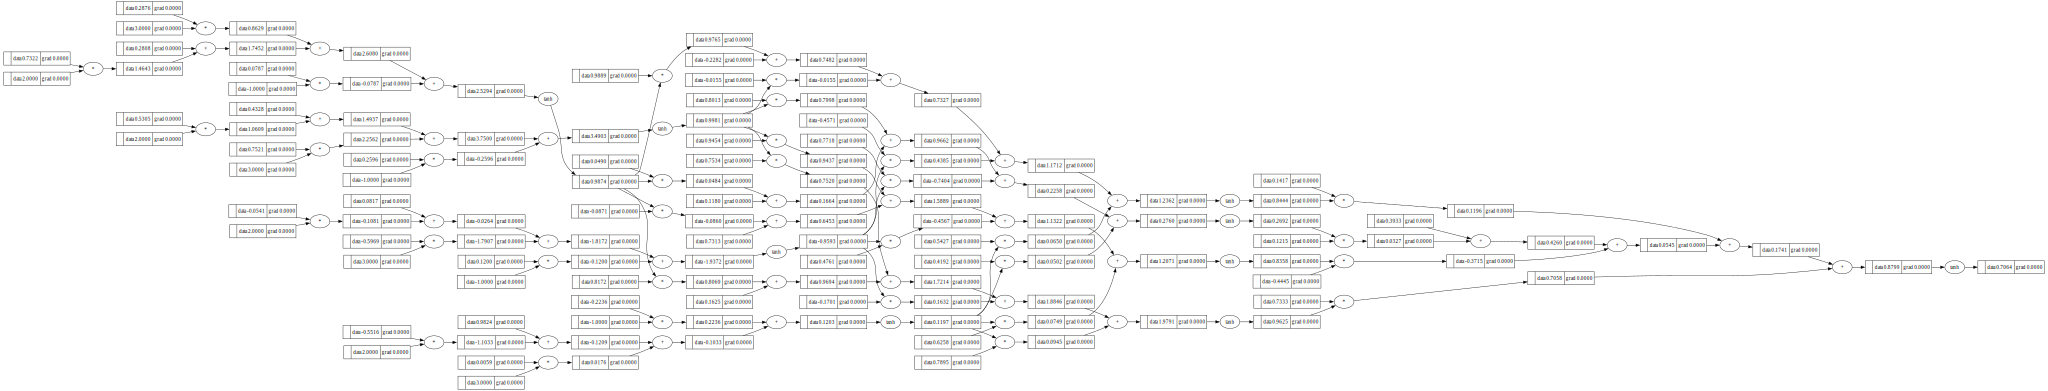

In [254]:
draw_dot(n(x))